In [1]:
from noise import decompress_pickle
from sklearn.model_selection import RandomizedSearchCV
import time
import numpy as np
from training_sktime import open_folds, find_max_value, normalizing, print_results
from  sktime.transformations.panel.reduce import Tabularizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
from functools import partial


INPUT_DATA_PATH = '../input-data/'
MODEL_PATH = './models/'

def param_optimization(X, y, model, grid, n_iter=50, cv=5):
    X = transform_tabular_data(X)
    rf_random = RandomizedSearchCV(estimator=model, param_distributions=grid,
                                   n_iter=n_iter, cv=cv, verbose=2,
                                   n_jobs=-1)
    rf_random.fit(X, y)
    return rf_random.best_params_

def transform_tabular_data(data, is_list=False):
    t= Tabularizer()
    if is_list:
        return list(map(t.fit_transform, data))
    else:
        return t.fit_transform(data)

def evaluating_model(model, X_test, y_test, cycle, scores, count, max_list, model_name='model', save=None):
    # Evaluating model
    score = model.score(X_test, y_test)
    scores.append(score)
    if save and (
        len(scores) != 1 and score > scores[count] or len(scores) == 1
    ):
        pickle.dump(model, open(MODEL_PATH + f'{model_name}_classifier_{cycle}.pkl', 'wb'))
        pickle.dump(max_list, open(MODEL_PATH + f'{model_name}_{cycle}_max_values.pkl', 'wb'))
    return scores

def kfold(train_X, train_y, test_X, test_y, model, cycle, max_list, model_name='', save=None):
    scores = []
    s = time.time()
    train_X = transform_tabular_data(train_X, is_list=True)
    test_X = transform_tabular_data(test_X, is_list=True)
    for count, (X_tr, y_tr, X_te, y_te) in enumerate(zip(train_X, train_y, test_X, test_y),
                                                     start=-1):
        X_tr_norm = transform_tabular_data(normalizing(X_tr, max_list))
        X_te_norm = transform_tabular_data(normalizing(X_te, max_list))
        model.fit(X_tr_norm, y_tr)
        scores = evaluating_model(model, X_te_norm, y_te, cycle, scores,
                                  count, max_list, model_name, save)
    e = time.time()
    final_scores = np.array(scores)
    print_results(cycle, model_name, final_scores, e, s, save)
    return np.mean(scores) * 100, np.round(e - s, 3)

def ref_grid():
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num=5)]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 20]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 6, 8, 10]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Division criterion
    criterion = ['entropy', 'gini']
    # Create the random grid
    random_grid = {'criterion': criterion,
                'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    rf = RandomForestClassifier()
    return rf, random_grid

In [13]:
cycle = 'cycle_1'
signal = 'i'
INPUT_DATA_PATH = '../input-data/'

train_X = open_folds(cycle, 'train', 'X', signal)
train_y = open_folds(cycle, 'train', 'y', signal)
test_X = open_folds(cycle, 'test', 'X', signal)
test_y = open_folds(cycle, 'test', 'y', signal)

X_train = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_train')
y_train = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/y_train')
X_val = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_val')
y_val = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/y_val')

max_list = find_max_value(X_train)
X_train_norm = normalizing(X_train, max_list)
X_val_norm = normalizing(X_val, max_list)

In [14]:
import matplotlib.pyplot as plt

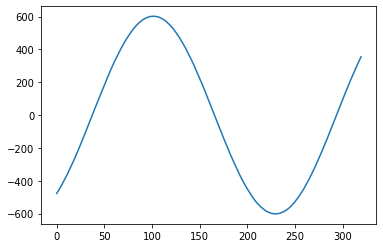

In [15]:
plt.plot(train_X[0].loc[14,'A'])